# Logistic classification with MNIST

(two predictors)

## Libraries

In [1]:
# libraries
#using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, f1score, coerce
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

#using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
#using Distributions

using Plots; gr()
#using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# feature extraction
meanIntensity(img) = mean(Float64.(img))

function hSymmetry(img)
    imgFloat = Float64.(img)
    imgReverse = reverse(imgFloat, dims=1)
    return -mean( abs.(imgFloat - imgReverse) )
end

hSymmetry (generic function with 1 method)

In [3]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(f1score(ŷ, y);  digits=3))
end


printMetrics (generic function with 1 method)

In [4]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

vector2Image(vec, h, v) = reshape(Float64.(vec), (h, v))

function rescaleByColumns(X)
    # using StatsBase
    X = Float64.(X)
    dt = StatsBase.fit(ZScoreTransform, X; dims=1, center=true, scale=true)
    rescaledX = StatsBase.transform(dt, X)
end


rescaleByColumns (generic function with 1 method)

## Loading the data

,,,,

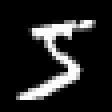
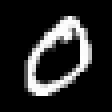
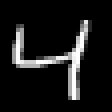
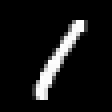
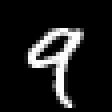

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [5]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [6]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Data preprocessing

Data preprocessing depends on the data source, thus can widely vary from what is shown here.

In [7]:
# convert images to vectors
trainX = batchImage2Vector(trainX)
trainX[1:5]

5-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [8]:
# select classes for prediction
c = (1, 5)

# data selection from above classes and sizes
trainX = vcat( trainX[trainY .== c[1] ], trainX[ trainY .== c[2] ] )
trainY = vcat( trainY[trainY .== c[1] ], trainY[ trainY .== c[2] ] )

display(levels(trainY))
size(trainX), size(trainY)

2-element Vector{Int64}:
 1
 5

((8514,), (8514,))

In [9]:
# generate predictors and outcome
function generatePredictors(X)
    N = size(X)[1]
    x1 = [meanIntensity(X[i]) for i in 1:N]
    x2 = [hSymmetry(X[i])     for i in 1:N]
    Xs = hcat(x1, x2)
    Xs = rescaleByColumns(Xs)
    
    return Xs
end

trainXLog = generatePredictors(trainX)
trainYLog = copy(trainY);


In [10]:
# specific conversions for the model to fit
trainXLog = DataFrame(trainXLog, :auto)
trainYLog = coerce(trainYLog, OrderedFactor);


## Training, Testing, Validation

### Load the algorithm

In [11]:
LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels verbosity=0

MLJLinearModels.LogisticClassifier

### Instantiate the model

In the context of MLJ, "model" means just a container for hyper-parameters.

It is worth to note the output of the below command line, which is a list of the actual values assigned for each hyper-parameters, including the default ones. This information can be useful, for exemple, for tuning the parameter at a later stage.

In [12]:
model = LogisticClassifier()

LogisticClassifier(
    lambda = 1.0,
    gamma = 0.0,
    penalty = :l2,
    fit_intercept = true,
    penalize_intercept = false,
    scale_penalty_with_samples = true,
    solver = nothing)

### Creates a machine

In MLJ, "machine" means an object with all learning parameters (i.e. hyper-parameters + trainset).

In [13]:
mach = MLJ.machine(model, trainXLog, trainYLog)

Machine{LogisticClassifier,…} trained 0 times; caches data
  model: MLJLinearModels.LogisticClassifier
  args: 
    1:	Source @746 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @969 ⏎ `AbstractVector{OrderedFactor{2}}`


### Train the machine

The machine (or model) is trained according to the programmed hyper-parameters and dataset:

In [14]:
fit!(mach,
    # acceleration = CPUThreads(),   # https://alan-turing-institute.github.io/MLJ.jl/v0.7/acceleration_and_parallelism/
    verbosity=2)

┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:464


Machine{LogisticClassifier,…} trained 1 time; caches data
  model: MLJLinearModels.LogisticClassifier
  args: 
    1:	Source @746 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @969 ⏎ `AbstractVector{OrderedFactor{2}}`


After training, one can inspect the learning parameters:

In [15]:
fitted_params(mach)

(classes = CategoricalArrays.CategoricalValue{Int64, UInt32}[1, 5],
 coefs = [:x1 => 0.22327300773694728, :x2 => -0.27803815922822733],
 intercept = -0.22368399037741235,)

Everything else the developer might be interested in, if any, can be accesses from the training report:

In [16]:
report(mach)

()

### Predict an outcome

The trained machine/model, stored in the object created for that purpose, is now used to predict the outcome for the trainset:

In [17]:
p = MLJ.predict(mach, trainXLog);


We can inspect a few rows of the prediction, then just a single row:

In [18]:
display(p[1:5])
p[1]

5-element CategoricalDistributions.UnivariateFiniteArray{OrderedFactor{2}, Int64, UInt32, Float64, 1}:
 UnivariateFinite{OrderedFactor{2}}(1=>0.633, 5=>0.367)
 UnivariateFinite{OrderedFactor{2}}(1=>0.704, 5=>0.296)
 UnivariateFinite{OrderedFactor{2}}(1=>0.698, 5=>0.302)
 UnivariateFinite{OrderedFactor{2}}(1=>0.632, 5=>0.368)
 UnivariateFinite{OrderedFactor{2}}(1=>0.647, 5=>0.353)

         UnivariateFinite{OrderedFactor{2}}     
     ┌                                        ┐ 
   1 ┤■■■■■■■■■■■■■■■■■■■■ 0.6330328095306961   
   5 ┤■■■■■■■■■■■■ 0.36696719046930387          
     └                                        ┘ 

For this particular model, the prediction is represented as probabilities for each of the classes. To translate that as the most likely class, we have:

In [19]:
ŷ = predict_mode(mach, trainXLog)
ŷ[1:5]

5-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 1
 1
 1
 1
 1

We can also extract relevant metrics as in the below example:

In [20]:
printMetrics(ŷ, trainYLog)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      5      │
├─────────────┼─────────────┼─────────────┤
│      1      │    4651     │    1281     │
├─────────────┼─────────────┼─────────────┤
│      5      │     68      │    2514     │
└─────────────┴─────────────┴─────────────┘


accuracy: 0.842
f1-score: 0.788


### Tune the hyper-parameters

When this particular model was instantiated above, one can see that the hyper-parameter "Lambda" could be of relevance to improve the model. Let's tune it as an attempt to minimize the cross-entropy loss and maximize accuracy.

First, we define the parameter and limits to scan:

In [21]:
r = range(model, :lambda, lower = 1e-5, upper=1e-1, scale = :log10)

NumericRange(1.0e-5 ≤ lambda ≤ 0.1; origin=0.050005, unit=0.049995000000000005) on log10 scale

Then, we define a 10-fold cross-validation, and capture the range parameter(lambdas) and the cross-entropy losses vectors (losses). The first two parameters of the tuple out of the function "learning_curve" are not relevent for this example, so are ignored:

In [22]:
_, _, lambdas, losses = learning_curve(mach,
                                        range=r,
                                        resampling=CV(nfolds=10),
                                        resolution=100,                 # default 30
                                        measure=cross_entropy,
                                        acceleration=CPUProcesses());   # useful if more than one parameter is plot

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:464
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/ciro/.julia/packages/MLJTuning/Al9yX/src/tuned_models.jl:680
Evaluating over 100 metamodels: 100%[=========================] Time: 0:00:28


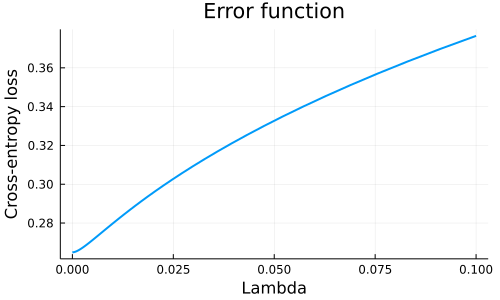

In [23]:
plot(lambdas, losses, title="Error function", size=(500,300), linewidth=2, legend=false)
xlabel!("Lambda")
ylabel!("Cross-entropy loss")

As seen on the chart above, the best tuning parameter is:

In [24]:
best_lambda = lambdas[argmin(losses)]

9.999999999999999e-6

### Retrain with best tuning parameter

(in progress)

In [25]:
model.lambda = best_lambda
fit!(mach,
    verbosity=2);

┌ Info: Updating Machine{LogisticClassifier,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:465


In [26]:
ŷ = predict_mode(mach, trainXLog)
printMetrics(ŷ, trainYLog)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      5      │
├─────────────┼─────────────┼─────────────┤
│      1      │    4399     │     474     │
├─────────────┼─────────────┼─────────────┤
│      5      │     320     │    3321     │
└─────────────┴─────────────┴─────────────┘


accuracy: 0.907
f1-score: 0.893


### Evaluate

(in progress)

In [27]:
MLJ.evaluate!(mach,
    resampling=CV(nfolds=10),
    measures=[f1score])


Evaluating over 10 folds: 100%[=========================] Time: 0:00:00


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌───────────────────────────────┬─────────────┬──────────────┬──────────────────
│ measure                       │ measurement │ operation    │ per_fold        ⋯
├───────────────────────────────┼─────────────┼──────────────┼──────────────────
│ FScore(β = 1.0,rev = nothing) │ 0.458       │ predict_mode │ [0.0, 0.0, 0.0, ⋯
└───────────────────────────────┴─────────────┴──────────────┴──────────────────
                                                                1 column omitted


In [28]:
fitted_params(mach)

(classes = CategoricalArrays.CategoricalValue{Int64, UInt32}[1, 5],
 coefs = [:x1 => 0.9187358219113964, :x2 => -3.5959349255921778],
 intercept = -0.21911107443348532,)

In [29]:
ŷ = predict_mode(mach, trainXLog)
printMetrics(ŷ, trainYLog)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      5      │
├─────────────┼─────────────┼─────────────┤
│      1      │    4460     │     539     │
├─────────────┼─────────────┼─────────────┤
│      5      │     259     │    3256     │
└─────────────┴─────────────┴─────────────┘


accuracy: 0.906
f1-score: 0.891


### Testing

In [30]:
# this function summarizes the steps taken during the preprocessing of the training dataset
# once preprocessing steps are defined, it is created as to ease usage on the test and validation sets

function preprocess(X, y)
    X = batchImage2Vector(X)
    
    preprocessX = vcat( X[y .== c[1] ], X[ y .== c[2] ] )
    preprocessY = vcat( y[y .== c[1] ], y[ y .== c[2] ] )

    preprocessX = generatePredictors(preprocessX)
    
    preprocessX = DataFrame(preprocessX, :auto)
    preprocessY = coerce(preprocessY, OrderedFactor)

    return (preprocessX, preprocessY)
end


preprocess (generic function with 1 method)

In [31]:
testXLog, testYLog = preprocess(testX, testY)

ŷ = predict_mode(mach, testXLog)
printMetrics(ŷ, testYLog)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      5      │
├─────────────┼─────────────┼─────────────┤
│      1      │    1916     │     227     │
├─────────────┼─────────────┼─────────────┤
│      5      │     107     │    1399     │
└─────────────┴─────────────┴─────────────┘


accuracy: 0.908
f1-score: 0.893


### Validation

In [32]:
validationXLog, validationYLog = preprocess(validationX, validationY)

ŷ = predict_mode(mach, validationXLog)
printMetrics(ŷ, validationYLog)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      5      │
├─────────────┼─────────────┼─────────────┤
│      1      │    1071     │     111     │
├─────────────┼─────────────┼─────────────┤
│      5      │     64      │     781     │
└─────────────┴─────────────┴─────────────┘


accuracy: 0.914
f1-score: 0.899


## Demonstration of the prediction

By pressing ENTER at the below cell several times, a randomly chosen slice of the actual outcome is compared to a correspondent slice of the predicted outcome. Due to the accuracy < 1 for the model, a few of them will not match.

,,,,,,,

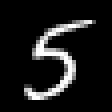
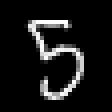
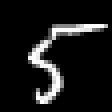
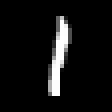
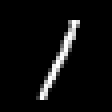
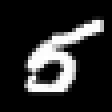
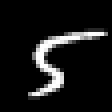
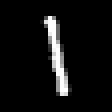

[5, 5, 5, 1, 1, 5, 5, 1]
CategoricalArrays.CategoricalValue{Int64, UInt32}[5, 5, 5, 1, 1, 5, 5, 1]


In [33]:
# demonstration of prediction accuracy
N = size(trainX)[1]
v = rand(1:N, 8)                            # select a random sample of images

trainXLog = generatePredictors(trainX[v])   # convert images to predictors
p = MLJ.predict(mach, trainXLog)            # predict outcome from sample images
ŷ = predict_mode(mach, trainXLog)           # convert probability to classes

display([MNIST.convert2image(vector2Image( trainX[i], 28, 28) ) for i in v])
println(trainY[v])
println(ŷ)